<a href="https://colab.research.google.com/github/vinitakawale/Diffusion_Model/blob/main/Diffusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Diffusion Model - Generate Images

In [6]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!mkdir data

In [9]:
!cp -r /content/drive/MyDrive/Diffusion_Models_Project/flowers /content/data

In [11]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.3 MB/s eta 0:00:00


In [6]:
!pip install openai-clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 8.4 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=30691d277ca4189aa494f741b3670ab457ffbe64f9d41c4d881100d0bbb32980
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip


In [12]:
import csv
import glob
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid
from textwrap import wrap

# User defined libraries
from utils import other_utils
from utils import ddpm_utils
from utils import UNet_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

There are a few different variations of CLIP based on popular image recognition neural networks:

In [8]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

For this notebook, we will be using `ViT-B/32`, which is based on the [Vision Transformer](https://huggingface.co/docs/transformers/main/model_doc/vit) architecture. It has `512` features, which we will later feed into our diffusion model.

In [9]:
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 172MiB/s]


Image Encodings

When we load CLIP, it will also come with a set of image transformations we can use to feed images into the CLIP model:

In [10]:
clip_preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x78fed786d360>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

We can test this on one of our flower photos. Let's start with a picturesque daisy.

In [11]:
!pip install opendatasets --upgrade --quiet

In [13]:
DATA_DIR = "data/flowers/"
img_path = DATA_DIR + "daisy/2877860110_a842f8b14a_m.jpg"
img = Image.open(img_path)
img.show()

We can find the CLIP embedding by first transforming our image with `clip_preprocess` and converting the result to a tensor. Since the `clip_model` expects a batch of images, we can use [np.stack](https://numpy.org/doc/stable/reference/generated/numpy.stack.html) to turn the processed image into a single element batch.

In [14]:
clip_imgs = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
clip_imgs.size()

torch.Size([1, 3, 224, 224])

Then, we can pass the batch to `clip_model.encode_image` to find the embedding for the image. Uncomment `clip_img_encoding` if you would like to see what an encoding looks like. When we print the size, it lists `512` features for our `1` image.

In [15]:
clip_img_encoding = clip_model.encode_image(clip_imgs)
print(clip_img_encoding.size())
#clip_img_encoding

torch.Size([1, 512])


### Text Encodings

Now that we have an image encoding, let's see if we can get a matching text encoding. Below is a list of different flower descriptions. Like with the images, the text needs to be preprocessed before it can be encoded by CLIP. To do this, CLIP comes with a `tokenize` function in order to convert each word into an integer.

In [16]:
text_list = [
    "A round white daisy with a yellow center",
    "An orange sunflower with a big brown center",
    "A red rose bud"
]
text_tokens = clip.tokenize(text_list).to(device)
text_tokens

tensor([[49406,   320,  2522,  1579, 12865,   593,   320,  4481,  2119, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   550,  4287, 21559,   593,   320,  1205,  2866,  2119, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

Then, we can pass the tokens to `encode_text` to get our text encodings. Uncomment `clip_text_encodings` if you would like to see what an encoding looks like. Similar to our image encoding, there are `512` features for each of our `3` images.

In [17]:
clip_text_encodings = clip_model.encode_text(text_tokens).float()
print(clip_text_encodings.size())
#clip_text_encodings

torch.Size([3, 512])


### Similarity

In order to see which one of our text descriptions best describes the daisy, we can calculate the [cosine similarity](https://medium.com/@milana.shxanukova15/cosine-distance-and-cosine-similarity-a5da0e4d9ded) between the text encodings and the image encodings. When the cosine similarity is `1`, it's a perfect match. When the cosine similarity is `-1`, the two encodings are opposites.

The cosine similarity is equivalent to a [dot product](https://mathworld.wolfram.com/DotProduct.html) with each vector normalized by their magnitude. In other words, the magnitude of each vector becomes `1`.

We can use the following formula to calculate the dot product:

$X \cdot Y = \sum_{i=1}^{n} x_i y_i = x_1y_1 + x_2 y_2 + \cdots  + x_n y_n$


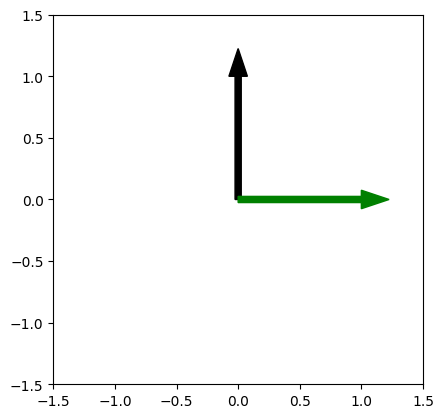

Cosine Similarity: 0.0


In [18]:
x1, y1 = [0, 1]
x2, y2 = [1, 0]

p1 = [x1, y1]
p2 = [x2, y2]

arrow_width = 0.05
plt.axis('square')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.arrow(0, 0, x1, y1, width=arrow_width, color="black")
plt.arrow(0, 0, x2, y2, width=arrow_width, color="green")
plt.show()

cosine = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
print("Cosine Similarity:", cosine)

The cosine similarity also works with multidimensional vectors, although they are harder to plot on a 2D surface.


In [19]:
p1 = [1, 8, 6, 7]
p2 = [5, 3, 0, 9]

cosine = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
print("Cosine Similarity:", cosine)

Cosine Similarity: 0.7004760286167305


Let's try calculating the similarity score for our CLIP encodings.

In [20]:
clip_img_encoding /= clip_img_encoding.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)
similarity = (clip_text_encodings * clip_img_encoding).sum(-1)
similarity

tensor([0.3707, 0.2473, 0.1768], device='cuda:0', grad_fn=<SumBackward1>)

In [21]:
for idx, text in enumerate(text_list):
    print(text, " - ", similarity[idx])

A round white daisy with a yellow center  -  tensor(0.3707, device='cuda:0', grad_fn=<SelectBackward0>)
An orange sunflower with a big brown center  -  tensor(0.2473, device='cuda:0', grad_fn=<SelectBackward0>)
A red rose bud  -  tensor(0.1768, device='cuda:0', grad_fn=<SelectBackward0>)


Below, we've added a sunflower and a rose image.

In [22]:
img_paths = [
    DATA_DIR + "/daisy/2877860110_a842f8b14a_m.jpg",
    DATA_DIR + "/sunflower/2721638730_34a9b7a78b.jpg",
    DATA_DIR + "/rose/8032328803_30afac8b07_m.jpg"
]

imgs = [Image.open(path) for path in img_paths]
for img in imgs:
    img.show()

In [23]:
def get_img_encodings(imgs):
    processed_imgs = [clip_preprocess(img) for img in imgs]
    clip_imgs = torch.tensor(np.stack(processed_imgs)).to(device)
    clip_img_encodings = clip_model.encode_image(clip_imgs)
    return clip_img_encodings

In [24]:
clip_img_encodings = get_img_encodings(imgs)
clip_img_encodings

tensor([[-0.2717, -0.0157, -0.1792,  ...,  0.5811,  0.0866, -0.1448],
        [ 0.1428, -0.0866, -0.2581,  ...,  0.5127,  0.2074, -0.0048],
        [-0.1198,  0.5830, -0.0645,  ...,  0.3027,  0.3315,  0.1141]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)

In [25]:
text_list = [
     "A round white daisy with a yellow center",
    "An orange sunflower with a big brown center",
    "A deep red rose flower"
]

In [26]:
text_tokens = clip.tokenize(text_list).to(device)
clip_text_encodings = clip_model.encode_text(text_tokens).float()
clip_text_encodings

tensor([[-0.5107,  0.1919,  0.1963,  ...,  0.0949, -0.0848, -0.2783],
        [ 0.0224,  0.3889,  0.3506,  ...,  0.1219,  0.0778, -0.1910],
        [-0.1094,  0.0110,  0.3333,  ...,  0.1288, -0.1019, -0.1853]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)

It would be nice to compare each combination of text and image. To do so, we can [repeat](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html#torch.Tensor.repeat) each text encoding for each image encoding. Similarly, we can [repeat_interleave](https://pytorch.org/docs/stable/generated/torch.repeat_interleave.html) each image encoding for each text encoding.

In [27]:
clip_img_encodings /= clip_img_encodings.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)

n_imgs = len(imgs)
n_text = len(text_list)

In [28]:
repeated_clip_text_encodings = clip_text_encodings.repeat(n_imgs, 1)
repeated_clip_text_encodings

tensor([[-0.0729,  0.0274,  0.0280,  ...,  0.0135, -0.0121, -0.0397],
        [ 0.0031,  0.0545,  0.0492,  ...,  0.0171,  0.0109, -0.0268],
        [-0.0135,  0.0014,  0.0410,  ...,  0.0158, -0.0125, -0.0228],
        ...,
        [-0.0729,  0.0274,  0.0280,  ...,  0.0135, -0.0121, -0.0397],
        [ 0.0031,  0.0545,  0.0492,  ...,  0.0171,  0.0109, -0.0268],
        [-0.0135,  0.0014,  0.0410,  ...,  0.0158, -0.0125, -0.0228]],
       device='cuda:0', grad_fn=<RepeatBackward0>)

In [29]:
repeated_clip_img_encoding = clip_img_encodings.repeat_interleave(n_text, dim=0)
repeated_clip_img_encoding

tensor([[-0.0247, -0.0014, -0.0163,  ...,  0.0528,  0.0079, -0.0132],
        [-0.0247, -0.0014, -0.0163,  ...,  0.0528,  0.0079, -0.0132],
        [-0.0247, -0.0014, -0.0163,  ...,  0.0528,  0.0079, -0.0132],
        ...,
        [-0.0112,  0.0545, -0.0060,  ...,  0.0283,  0.0310,  0.0107],
        [-0.0112,  0.0545, -0.0060,  ...,  0.0283,  0.0310,  0.0107],
        [-0.0112,  0.0545, -0.0060,  ...,  0.0283,  0.0310,  0.0107]],
       device='cuda:0', dtype=torch.float16, grad_fn=<ViewBackward0>)

In [30]:
similarity = (repeated_clip_text_encodings * repeated_clip_img_encoding).sum(-1)
similarity = torch.unflatten(similarity, 0, (n_text, n_imgs))
similarity

tensor([[0.3705, 0.2471, 0.1943],
        [0.2541, 0.2803, 0.1707],
        [0.1655, 0.1668, 0.3193]], device='cuda:0', grad_fn=<ViewBackward0>)

Let's compare. Ideally, the diagonal from the top left to the bottom right should be a bright yellow corresponding to their high value. The rest of the values should be low and blue.

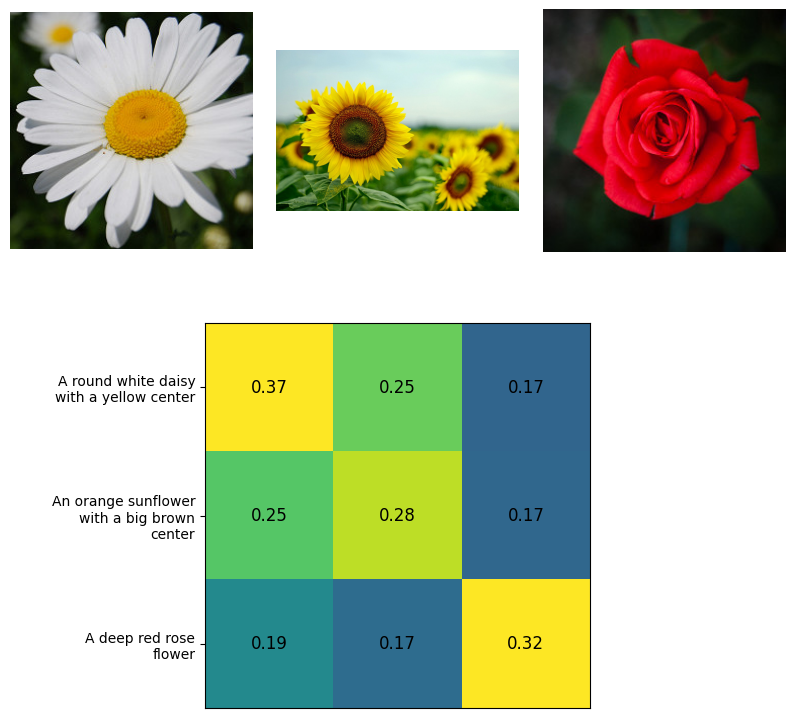

In [31]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 3, wspace=.1, hspace=0)

for i, img in enumerate(imgs):
    ax = fig.add_subplot(gs[0, i])
    ax.axis("off")
    plt.imshow(img)

ax = fig.add_subplot(gs[1, :])
plt.imshow(similarity.detach().cpu().numpy().T, vmin=0.1, vmax=0.3)

labels = [ '\n'.join(wrap(text, 20)) for text in text_list ]
plt.yticks(range(n_text), labels, fontsize=10)
plt.xticks([])

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[x, y]:.2f}", ha="center", va="center", size=12)

## A CLIP Dataset

The next code block runs the following loop for each filepath:
* Open the image associated with the path and store it in `img`
* Preprocess the image, find the CLIP encoding, and store it in `clip_img`
* Convert the CLIP encoding from a tensor to a python list
* Store the filepath and the CLIP encoding as a row in a csv file

In [32]:
data_paths = glob.glob(DATA_DIR + '*/*.jpg', recursive=True)
data_paths[:5]

['data/flowers/daisy/3450822975_7e77d67636_n.jpg',
 'data/flowers/daisy/9225336602_e6c392f941_n.jpg',
 'data/flowers/daisy/34531542152_c8ba2e0fea_n.jpg',
 'data/flowers/daisy/34696730126_056ffea63c_n.jpg',
 'data/flowers/daisy/144076848_57e1d662e3_m.jpg']

In [33]:
csv_path = 'clip.csv'

with open(csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for idx, path in enumerate(data_paths):
        img = Image.open(path)
        clip_img = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
        label = clip_model.encode_image(clip_img)[0].tolist()
        writer.writerow([path] + label)

It may take a few seconds to process the full dataset. When complete, open [clip.csv](clip.csv) to see the results.



In [34]:
IMG_SIZE = 32 # Due to stride and pooling, must be divisible by 2 multiple times
IMG_CH = 3
BATCH_SIZE = 128
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

pre_transforms = [
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
]
pre_transforms = transforms.Compose(pre_transforms)
random_transforms = [
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
]
random_transforms = transforms.Compose(random_transforms)

Below is the code to initialize our new dataset. Since we've `preprocessed_clip`, we will preload it onto our GPU with the `__init__` function. We've kept the "on the fly" CLIP encoding as an example. It will produce slightly better results, but it is much slower.

In [35]:
class MyDataset(Dataset):
    def __init__(self, csv_path, preprocessed_clip=True):
        self.imgs = []
        self.preprocessed_clip = preprocessed_clip
        if preprocessed_clip:
            self.labels = torch.empty(
                len(data_paths), CLIP_FEATURES, dtype=torch.float, device=device
            )

        with open(csv_path, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for idx, row in enumerate(reader):
                img = Image.open(row[0])
                self.imgs.append(pre_transforms(img).to(device))
                if preprocessed_clip:
                    label = [float(x) for x in row[1:]]
                    self.labels[idx, :] = torch.FloatTensor(label).to(device)

    def __getitem__(self, idx):
        img = random_transforms(self.imgs[idx])
        if self.preprocessed_clip:
            label = self.labels[idx]
        else:
            batch_img = img[None, :, :, :]
            encoded_imgs = clip_model.encode_image(clip_preprocess(batch_img))
            label = encoded_imgs.to(device).float()[0]
        return img, label

    def __len__(self):
        return len(self.imgs)

In [36]:
train_data = MyDataset(csv_path)
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [37]:
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)

ddpm = ddpm_utils.DDPM(B, device)
model = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=CLIP_FEATURES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model_flowers = torch.compile(model.to(device))

Num params:  44900355


In [38]:
def get_context_mask(c, drop_prob):
    c_mask = torch.bernoulli(torch.ones_like(c).float() - drop_prob).to(device)
    return c_mask

In [39]:
def sample_flowers(text_list):
    text_tokens = clip.tokenize(text_list).to(device)
    c = clip_model.encode_text(text_tokens).float()
    x_gen, x_gen_store = ddpm_utils.sample_w(model, ddpm, INPUT_SIZE, T, c, device)
    return x_gen, x_gen_store

Training - After about `50` `epochs`, the model will start generating something recognizable, and at `100` it will hit its stride.

In [40]:
epochs=100
c_drop_prob = 0.1
lrate = 1e-4
save_dir = "05_images/"

In [41]:
!mkdir 05_images

mkdir: cannot create directory ‘05_images’: File exists


In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x, c = batch
        c_mask = get_context_mask(c, c_drop_prob)
        loss = ddpm.get_loss(model_flowers, x, t, c, c_mask)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
    if epoch % 5 == 0 or epoch == int(epochs - 1):
        x_gen, x_gen_store = sample_flowers(text_list)
        grid = make_grid(x_gen.cpu(), nrow=len(text_list))
        save_image(grid, save_dir + f"image_ep{epoch:02}.png")
        print("saved images in " + save_dir + f" for episode {epoch}")

Epoch 0 | Step 032 | Loss: 0.19544288516044617
saved images in 05_images/ for episode 0
Epoch 1 | Step 032 | Loss: 0.132981538772583
Epoch 2 | Step 032 | Loss: 0.133782297372818
Epoch 3 | Step 032 | Loss: 0.15412235260009766
Epoch 4 | Step 032 | Loss: 0.1198103055357933
Epoch 5 | Step 032 | Loss: 0.12722229957580566
saved images in 05_images/ for episode 5
Epoch 6 | Step 032 | Loss: 0.10928925126791
Epoch 7 | Step 032 | Loss: 0.1157999262213707
Epoch 8 | Step 032 | Loss: 0.11118891835212708
Epoch 9 | Step 032 | Loss: 0.09184819459915161
Epoch 10 | Step 032 | Loss: 0.10234548896551132
saved images in 05_images/ for episode 10
Epoch 11 | Step 032 | Loss: 0.10589075088500977
Epoch 12 | Step 032 | Loss: 0.08621157705783844
Epoch 13 | Step 032 | Loss: 0.06884771585464478
Epoch 14 | Step 032 | Loss: 0.08864161372184753
Epoch 15 | Step 032 | Loss: 0.08148375153541565
saved images in 05_images/ for episode 15
Epoch 16 | Step 032 | Loss: 0.08010312169790268
Epoch 17 | Step 032 | Loss: 0.0870698

Now that the model is trained, We can try crafting some prompts to generate images.


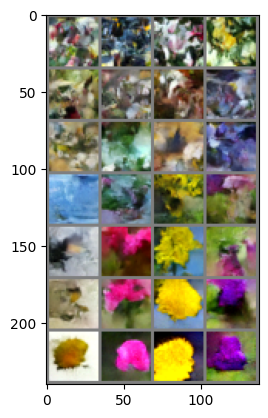

In [53]:
# Change me
text_list = [
    "A daisy",
    "A pink rose",
    "A yellow sunflower",
    "A purple rose"
  ]

model.eval()
x_gen, x_gen_store = sample_flowers(text_list)
grid = make_grid(x_gen.cpu(), nrow=len(text_list))
other_utils.show_tensor_image([grid])
plt.show()

Once you've found a set of images you enjoy, run the below cell to turn it into an animation. It will be saved to [05_images/flowers.gif](05_images/flowers.gif)

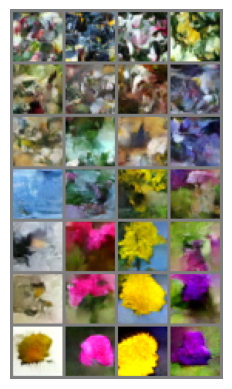

In [54]:
grids = [other_utils.to_image(make_grid(x_gen.cpu(), nrow=len(text_list))) for x_gen in x_gen_store]
other_utils.save_animation(grids, "05_images/flowers.gif")